# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>


## PyTorch и полносвязные нейронные сети

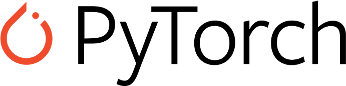

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set(palette='Set2', font_scale=1.5)

import torch
from torch import nn
import torch.nn.functional as F

print(torch.__version__)

2.0.1+cpu


#### 1.1 Сравнение NumPy и PyTorch-синтаксиса 
Интерфейс `torch` написан подобно <a href="https://miptstats.github.io/courses/python/05_numpy.html" target="_blank">интерфейсу</a> `numpy` для удобства использования. Главное различие между ними в том, что `numpy` оперирует `numpy.ndarray` массивами, а `torch` &mdash; тензорами `torch.Tensor`. Тензор в `torch`, как и массив в `numpy` представляет собой многомерную матрицу с элементами одного типа данных. Напишем одни и те же операции на `numpy` и `torch`.

**numpy**

In [2]:
x = np.arange(16).reshape(4, 4)

print("Матрица X:\n{}\n".format(x))
print("Размер: {}\n".format(x.shape))
print("Добавление константы:\n{}\n".format(x + 5))
print("X*X^T:\n{}\n".format(np.dot(x, x.T)))
print("Среднее по колонкам:\n{}\n".format(x.mean(axis=-1)))
print("Кумулятивная сумма по колонкам:\n{}\n".format(np.cumsum(x, axis=0)))

Матрица X:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

Размер: (4, 4)

Добавление константы:
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T:
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

Среднее по колонкам:
[ 1.5  5.5  9.5 13.5]

Кумулятивная сумма по колонкам:
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



**pytorch**

In [3]:
x = np.arange(16).reshape(4, 4)
x = torch.tensor(x, dtype=torch.float32)  # или torch.arange(0,16).view(4,4)

print("Матрица X:\n{}".format(x))
print("Размер: {}\n".format(x.shape))
print("Добавление константы:\n{}".format(x + 5))
print("X*X^T:\n{}".format(torch.matmul(x, x.transpose(1, 0))))  # кратко: x.mm(x.t())
print("Среднее по колонкам:\n{}".format(torch.mean(x, dim=-1)))
print("Кумулятивная сумма по колонкам:\n{}".format(torch.cumsum(x, dim=0)))

Матрица X:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
Размер: torch.Size([4, 4])

Добавление константы:
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
Среднее по колонкам:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
Кумулятивная сумма по колонкам:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Все же некоторые названия методов отличаются от `numpy`-евских. Полной совместимости с `numpy` пока нет, но от версии к версии разрыв сокращается, и придется снова запоминать новые названия для некоторых методов.

Например, PyTorch имеет другое написание стандартных типов
 * `x.astype('int64') -> x.type(torch.LongTensor)`


Для более подробного ознакомления можно посмотреть на <a href="https://github.com/torch/torch7/wiki/Torch-for-Numpy-users" target="_blank">табличку</a> перевода методов из `numpy` в `torch`, а также заглянуть в <a href="http://pytorch.org/docs/master/" target="_blank">документацию</a>. Также при возникновении проблем часто помогает зайти на <a href="https://discuss.pytorch.org/" target="_blank">pytorch forumns</a>.

#### 1.2 NumPy <-> PyTorch
Можно переводить `numpy`-массив в `torch`-тензор и наоборот.
Например, чтобы сделать из `numpy`-массива `torch`-тензор, можно поступить следующим образом

In [4]:
# зададим numpy массив
x_np = np.array([2, 5, 7, 1])

# 1-й способ
x_torch = torch.tensor(x_np) 
print(type(x_torch), x_torch)

# 2-й способ
x_torch = torch.from_numpy(x_np)
print(type(x_torch), x_torch)

<class 'torch.Tensor'> tensor([2, 5, 7, 1], dtype=torch.int32)
<class 'torch.Tensor'> tensor([2, 5, 7, 1], dtype=torch.int32)


Аналогично и с переводом обратно: функция `x.numpy()` переведет `torch`-тензор `x` в `numpy`-массив, причем типы переведутся соответственно <a href="https://github.com/torch/torch7/wiki/Torch-for-Numpy-users" target="_blank">табличке</a>.

In [5]:
x_np = x_torch.numpy()
print(type(x_np), x_np)

<class 'numpy.ndarray'> [2 5 7 1]


#### 1.3 Еще один пример
Нарисуем по сетке данную кривую на графике, используя `torch`:

$$x(t) = 2 \cos t + \sin 2t \cos 60t,$$

$$y(t) = \sin 2t + \sin 60t.$$

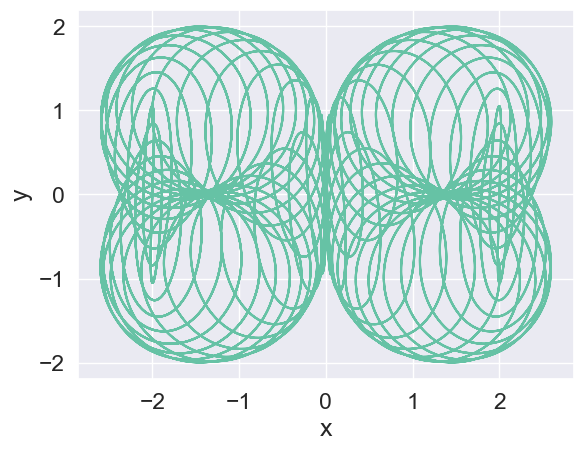

In [6]:
t = torch.linspace(-10, 10, steps=10000)
x = 2 * torch.cos(t) + torch.sin(2 * t) * torch.cos(60 * t)
y = torch.sin(2 * t) + torch.sin(60 * t)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Заметим, что библиотека `matplotlib` справляется с отображением `pytorch`-тензоров, и дополнительных преобразований делать не нужно.



### 2. Простой пример обучения нейронной сети


#### 2.1 Цикл обучения модели

Пусть задана нейронная сеть $f(x)$, параметризуемая обучаемыми параметрами $\theta$. Для входных данных $x$ модель возращает $\widehat{y}=f(x)$. Для обучения модели необходимо задать оптимизируемую функцию (функцию ошибки, лосс) $L(y, \widehat{y})$, которую следует минимизовать. 


Процесс обучения задается следующим образом.
 * **Прямой проход / Forward pass:** <br>
     Считаем $\widehat{y}=f(x)$ для входных данных $x$. <br>
 * **Вычисление оптимизируемой функции:**<br>
     Вычисляем оптимизируемую функцию $L(y, \widehat{y})$. <br>
 * **Обратный проход / Backward pass:** <br>
     Считаем градиенты по всем обучаемым параметрам $\frac{\partial L}{\partial \theta}$. <br>
 * **Шаг оптимизации:** <br>
     Делаем шаг градиентного спуска, обновляя все обучаемые параметры. <br>
    

#### 2.2 Линейная регрессия

В лекциях показано, что линейную регрессию можно представить как частный случай нейрона с тождественной функцией активации. 

Сделаем одномерную линейную регрессию на датасете <a href="http://lib.stat.cmu.edu/datasets/boston" target="_blank">boston</a>. Этот датасет представляет собой набор данных конца 70-х годов прошлого века для предсказания цены недвижимости в Бостоне. 

Скачиваем данные.

In [7]:
def load_boston():
    # ссылка для скачивания данных
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    # собираем таблицу данных
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    # выделяем признаки и таргет
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

In [8]:
data, target = load_boston()

Будем рассматривать зависимость таргета, т.е. медианной стоимости домов в тысячах долларов, от последнего признака, т.е. процента населения людей с низким уровнем дохода.

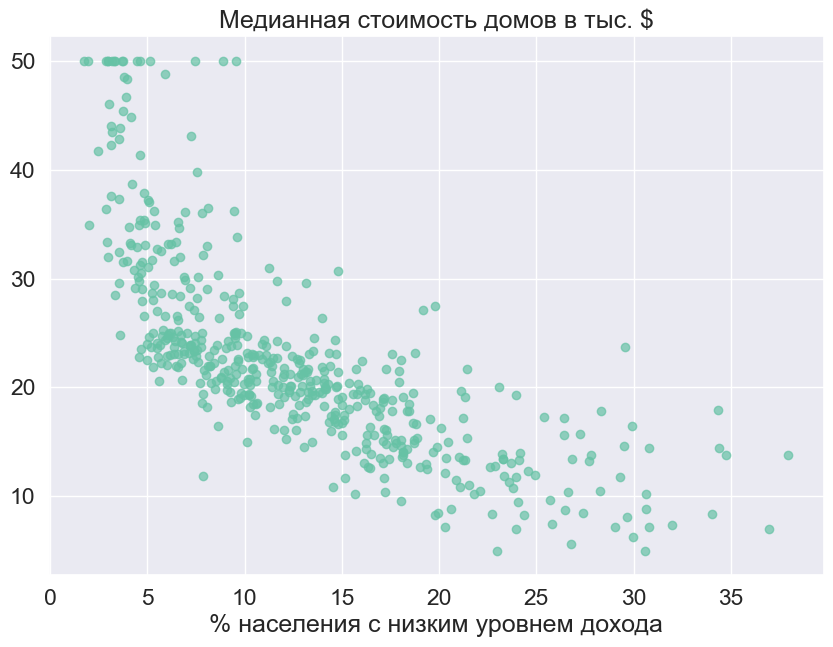

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:, -1], target, alpha=0.7)
plt.xlabel('% населения с низким уровнем дохода')
plt.title('Медианная стоимость домов в тыс. $');

В данном случае предсказание модели задается следующим образом: $$\widehat{y}(x) = wx + b,$$
где $w, b \in \mathbb{R}$ &mdash; обучаемые параметры модели. Это обычная линейная модель, и с ней мы уже работали <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html" target="_blank">ранее</a>.

Объявляем обучаемые параметры. Также задаем признак $X$ и таргет $Y$ в виде `torch`-тензоров. 

In [10]:
# создаем два тензора размера 1 с заполнением нулями, 
# для которых будут вычисляться градиенты
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Данные оборачиваем в тензоры, по которым не требуем вычисления градиента
x = torch.FloatTensor(data[:, -1] / 10)
y = torch.FloatTensor(target)

# по-другому:
# x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
# y = torch.tensor(boston.target, dtype=torch.float32)

In [11]:
print(x.shape)
print(y.shape)

torch.Size([506])
torch.Size([506])


Зададим оптимизируемую функцию / функцию ошибки / лосс &mdash; <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html#3.-Тестирование-и-оценка-качества" target="_blank">MSE</a>:

$$
\mathrm{MSE}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n \left(\widehat{y}_i - y_i\right)^2.
$$


In [12]:
def optim_func(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

После того, как мы посчитаем результат применения этой функции к нашим данным, нам необходимо посчитать градиенты по всем обучаемым параметрам, чтобы затем сделать шаг градиентного спуска. В этом нам поможет функция `backward`. Вызвав `backward` для результата подсчета функции ошибки `loss`, мы сделаем обратный проход по всему графу вычислений и посчитаем градиенты лосса по всем обучаемым параметрам. Подробнее о том, как это работает будет рассказано на 3 курсе.

In [13]:
# Прямой проход
y_pred = w * x + b

# Вычисление лосса
loss = optim_func(y_pred, y)

# Вычисление градиентов 
# с помощью обратного прохода по сети 
# и сохранение их в памяти сети
loss.backward()

Здесь `loss` &mdash; значение функции MSE, вычисленное на этой итерации.

In [14]:
loss

tensor(592.1469, grad_fn=<MeanBackward0>)

К градиентам для обучаемых параметров, которые требуют градиента (`requires_grad=True`), теперь можно обратиться следующим образом:

In [15]:
print("dL/dw =", w.grad)
print("dL/b =", b.grad)

dL/dw = tensor([-47.3514])
dL/b = tensor([-45.0656])


Если мы посчитаем градиент $M$ раз, то есть $M$ раз вызовем `loss.backward()`, то градиент будет накапливаться (суммироваться) в параметрах, требующих градиента. Иногда это бывает удобно.

Убедимся на примере, что именно так все и работает.

In [16]:
y_pred = w * x + b
loss =  optim_func(y_pred, y)
loss.backward()

print("dL/dw =", w.grad)
print("dL/b =", b.grad)

dL/dw = tensor([-94.7029])
dL/b = tensor([-90.1312])


Видим, что значения градиентов стали в 2 раза больше, за счет того, что мы сложили одни и те же градиенты 2 раза.

Если же мы не хотим, чтобы градиенты суммировались, то нужно **занулять
градиенты** между итерациями после того как сделали шаг градиентного спуска.
Это можно сделать с помощью функции `zero_` для градиентов.


In [17]:
w.grad.zero_()
b.grad.zero_()
w.grad, b.grad

(tensor([0.]), tensor([0.]))

Соберем в единый пайплайн весь рассмотренный выше процесс для совершения нескольких итераций обучения. Также напишем функцию визуализации процесса обучения.

In [18]:
def show_progress(x, y, y_pred, loss):
    '''
    Визуализация процесса обучения.
    
    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Избавимся от градиентов перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число, для красивого отображения
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75)
    plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.xlabel('% населения с низким уровнем дохода')
    plt.title('Медианная стоимость домов в тыс. $')
    plt.show()

    print(f"MSE = {loss:.3f}")

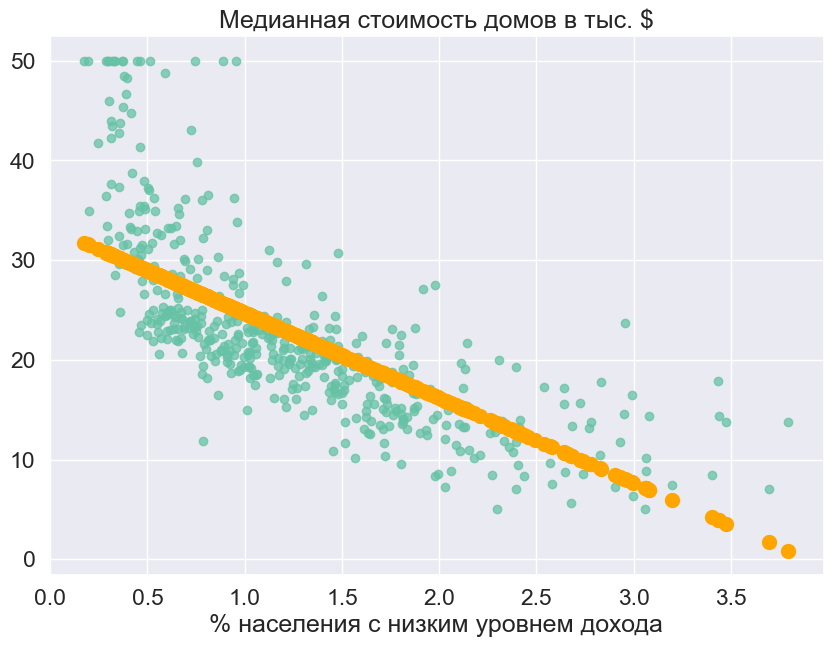

MSE = 38.978
Готово!


In [19]:
# Инициализация параметров
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Количество итераций
num_iter = 1000

# Скорость обучения для параметров
lr_w = 0.01
lr_b = 0.05

for i in range(num_iter):

    # Forward pass: предсказание модели
    y_pred = w * x + b

    # Вычисление оптимизируемой функции (MSE)
    loss = optim_func(y_pred, y)

    # Обратный проход: вычисление градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    w.data -= lr_w * w.grad.data
    b.data -= lr_b * b.grad.data

    # Зануление градиентов
    w.grad.zero_()
    b.grad.zero_()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 39:
            print("Готово!")
            break

#### 2.3 Улучшение модели

Попробуем усложнить модель, добавив еще один слой. Тем самым модель примет следующий вид

$$\widehat{y}(x) = w_2u(x) + b_2,$$

$$u(x) = \sigma(w_1x + b_1),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_2, b_2 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае мы выбрали `ReLU`. Можно заметить, что это функция не удовлетворяет условиям теоремы Цыбенко, тем не менее на практике она часто применяется для нейронных сетей.

In [20]:
# Инициализация параметров
import torch.nn.functional as F

class TwoLayerRegressionNet(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(TwoLayerRegressionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,1)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        return self.fc2(X)

# Количество итераций
num_iter = 100

model = TwoLayerRegressionNet(1,10)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)
criterion = nn.MSELoss()

for i in range(num_iter):

    # Forward pass: предсказание модели
    y_pred =  model(x.view(-1,1))

    # Вычисление оптимизируемой функции (MSE)
    loss = criterion(y_pred.view(-1),y)

    # Bakcward pass: вычисление градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    optimizer.step()
    optimizer.zero_grad()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 200 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 25:
            print("Готово!")
            break

Что изменилось?

**Ответ:** у модели появились дополнительные степени свободы для аппроксимации нелинейной зависимости. Видим, что также возможна аппроксимация и немонотонных зависимостей  

### 3. Готовые модули из PyTorch

На практике нейронные сети так не пишут, а пользуются готовыми модулями. Напишем такую же нейросеть, но теперь с помощью `torch`. Для этого будем пользоваться `torch.nn`.

Воспользуемся следующими модулями:

* `nn.Sequential` &mdash; модуль для соединения модулей последовательно, друг за другом;
* `nn.Linear` &mdash; модуль линейного слоя (без функции активации);
* `nn.ReLU` &mdash; модуль функции активации ReLU.

In [21]:
# собираем модули в последовательность
model = nn.Sequential(
    # кол-во признаков во входном слое 1, в выходном тоже 1
    nn.Linear(in_features=1, out_features=1), 
    # та же ф-ция активации, что и раньше, только из pytorch 
    nn.ReLU(),  
    # кол-во признаков во входном слое 1, в выходном тоже 1
    nn.Linear(in_features=1, out_features=1)  
)

model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

Для того, чтобы работать с данной моделью, нам необходимо поменять размерность `x` и `y`.

In [22]:
x_new = x.reshape(-1, 1)
y_new = y.reshape(-1, 1)

Применим модель к нашим данным и посмотрим на результаты для первых 10 элементов.

In [23]:
model(x_new)[:10]

tensor([[-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654],
        [-0.8654]], grad_fn=<SliceBackward0>)

Посмотрим на обучаемые параметры модели с помощью функции `named_parameters`, которая, кроме параметров, выдает также их названия. Имена `0.weight` и `0.bias` соответствуют весу $w_1$ и сдвигу $b_1$ первого слоя, аналогично, `2.weight` и `2.bias` соотвествуют весу $w_2$ и сдвигу $b_2$ второго слоя. Заметим, что в названии параметров есть индексы $0$ и $2$, но нет индекса $1$, т.к. $0$-й и $2$-й модули в модели представлены линейными слоями, а $1$-й модуль &mdash; функцией активации, у которой нет обучаемых параметров.

In [24]:
for name, param in model.named_parameters():
    print(name)
    print(param.data)

0.weight
tensor([[-0.9872]])
0.bias
tensor([-0.4230])
2.weight
tensor([[-0.2255]])
2.bias
tensor([-0.8654])


Инициализируем параметры так же, как мы делали для подобной модели ранее. На этот раз воспользуемся функцией `parameters`, она возвращает только параметры.

In [25]:
for p in model.parameters():
    p.data = torch.FloatTensor([[1]])
    print(p.data)

tensor([[1.]])
tensor([[1.]])
tensor([[1.]])
tensor([[1.]])


Ранее мы производили оптимизацию самостоятельно. Теперь же сделаем это с помощью оптимизатора `SGD` из `torch`, который реализует стохастический градиентный спуск. Он принимает на вход параметры модели, их мы можем получить, вызвав метод `parameters` у модели, и скорость обучения `lr`, которую мы обозначали ранее как $\eta$. У оптимизатора есть возможность задать некоторые другие аргументы, но их мы рассмотрим уже на 3 курсе.

Установим скорость обучения на уровне $0.01$ для всех параметров сразу. Также заменим нашу написанную `MSE` функцию на соответствующую из `torch`.

In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optim_func = nn.MSELoss()

Обучим полученную модель на наших данных. Теперь обновления значений параметров происходят с помощью вызова `optimzer.step()`, а зануление градиентов &mdash; с помощью `optimizer.zero_grad()`.

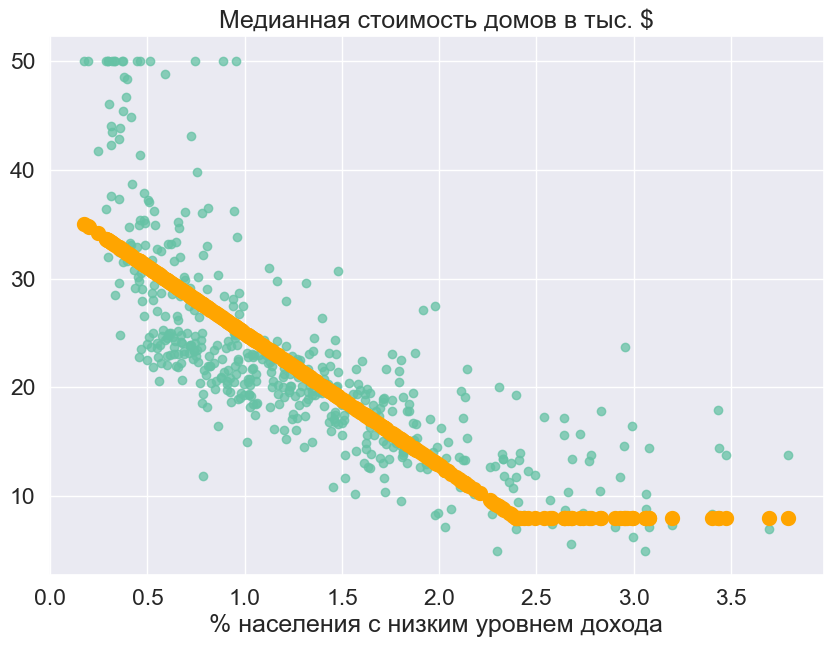

MSE = 34.986
Готово!


In [27]:
# Количество итераций
num_iter = 10000

for i in range(num_iter):

    # Forward pass: предсказание модели по данным x_new
    y_pred = model(x_new)

    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_new)

    # Bakcward pass: вычисление градиентов оптимизируемой функции 
    # по всем параметрам модели
    loss.backward()

    # Оптимизация: обновление параметров по формулам соответствующего 
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 35:
            print("Готово!")
            break

Полученная модель довольно хорошо приближает данные, однако дольше сходится к оптимуму за счет меньшей скорости обучения для параметров сдвига.


### Исследование параметров нейронной сети

#### 1. Learning rate

Увеличьте параметр `learning rate` в оптимизаторе до 0.1 и повторите обучение модели. Инициализируем параметры заново.

In [28]:
for p in model.parameters():
    p.data = torch.FloatTensor([[1]])
    print(p.data)

tensor([[1.]])
tensor([[1.]])
tensor([[1.]])
tensor([[1.]])


In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optim_func = nn.MSELoss()

Обучите модель.

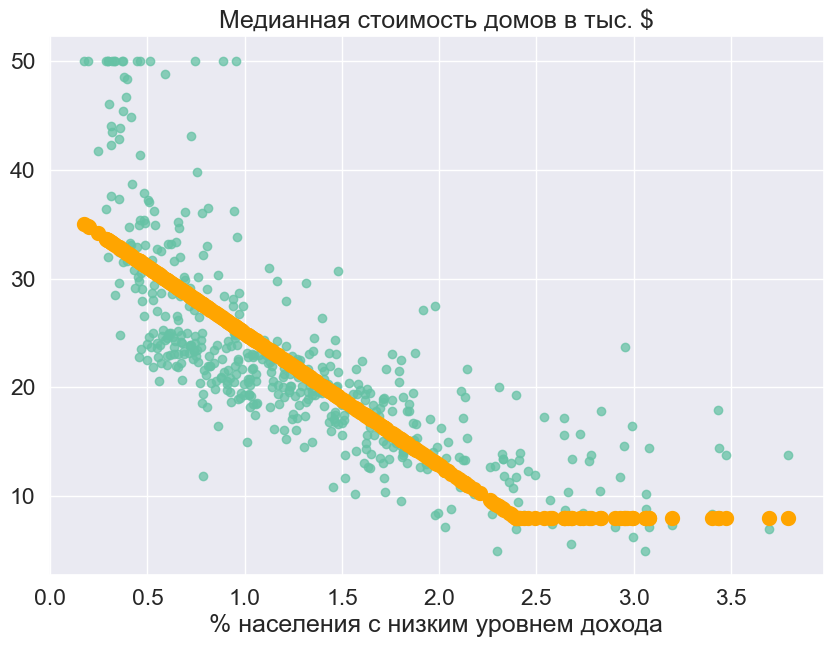

MSE = 34.986
Готово!


In [31]:
# Количество итераций
num_iter = 10000

for i in range(num_iter):

    # Forward pass: предсказание модели по данным x_new
    y_pred = model(x_new)

    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_new)

    # Bakcward pass: вычисление градиентов оптимизируемой функции 
    # по всем параметрам модели
    loss.backward()

    # Оптимизация: обновление параметров по формулам соответствующего 
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 35:
            print("Готово!")
            break
    

Что изменилось в процессе обучения? Стало ли предсказание лучше?

**Ответ:** предсказание не изменилось, поскольку задано порогом MSE. Наблюдал более долгое блуждание кривой относительно оптимального решения. Связываю это с тем, что при спуске к локальному минимуму решение пересекало оптимум в силу величины learning rate

#### 2. Увеличение количества признаков

Теперь построим нейронную четь на всех признаках, которые нам даны в датасете. Презапишем наши переменные.

In [32]:
x_full = torch.FloatTensor(data / 10)
y = torch.FloatTensor(target)

In [33]:
x_new = x_full
y_new = y.reshape(-1, 1)

x_new.shape, y_new.shape

(torch.Size([506, 13]), torch.Size([506, 1]))

Создайте нейронную сеть, которая принимает на вход 13 признаков.

In [34]:
model = nn.Sequential(
    nn.Linear(13,26),
    nn.ReLU(),
    nn.BatchNorm1d(26),
    nn.Linear(26,13),
    nn.ReLU(),
    nn.BatchNorm1d(13),
    nn.Linear(13,1)
)
model

Sequential(
  (0): Linear(in_features=13, out_features=26, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=26, out_features=13, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=13, out_features=1, bias=True)
)

Посмотрим как выглядят наши параметры.

In [35]:
for p in model.parameters():
    print(p.data)

tensor([[ 0.1662, -0.2727, -0.1466, -0.1381, -0.1826, -0.1274, -0.2213, -0.1053,
         -0.1939, -0.1150, -0.0971,  0.1734, -0.0192],
        [-0.2508, -0.1960,  0.0878,  0.1184,  0.2707, -0.1544,  0.0110, -0.0711,
          0.1172,  0.1028,  0.2518, -0.1337, -0.2323],
        [-0.1848, -0.1813, -0.2534,  0.0154,  0.0888, -0.2138, -0.1443, -0.0333,
          0.2188,  0.0020,  0.2528,  0.1754, -0.1624],
        [-0.0811,  0.2644,  0.2393, -0.1305,  0.2652, -0.1273,  0.2467, -0.0265,
         -0.0970,  0.0982,  0.0003, -0.2710,  0.0296],
        [-0.1484,  0.2464,  0.1949, -0.0754,  0.0569, -0.0408,  0.1326, -0.1226,
         -0.0041,  0.0630, -0.0346, -0.1203, -0.1005],
        [ 0.2458,  0.2723, -0.1061, -0.0944,  0.0226, -0.1246,  0.1044,  0.0268,
         -0.2212, -0.2117, -0.1541,  0.2604, -0.1728],
        [ 0.0657,  0.2171, -0.0899,  0.1585, -0.1814,  0.2258, -0.0724, -0.2411,
         -0.0724,  0.0251, -0.2613,  0.1567, -0.1131],
        [ 0.0049,  0.2178, -0.1799, -0.1698, -0.

Зададим оптимизатор.

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optim_func = nn.MSELoss()

Обучите модель. В этой задаче отрисовку делать не надо.

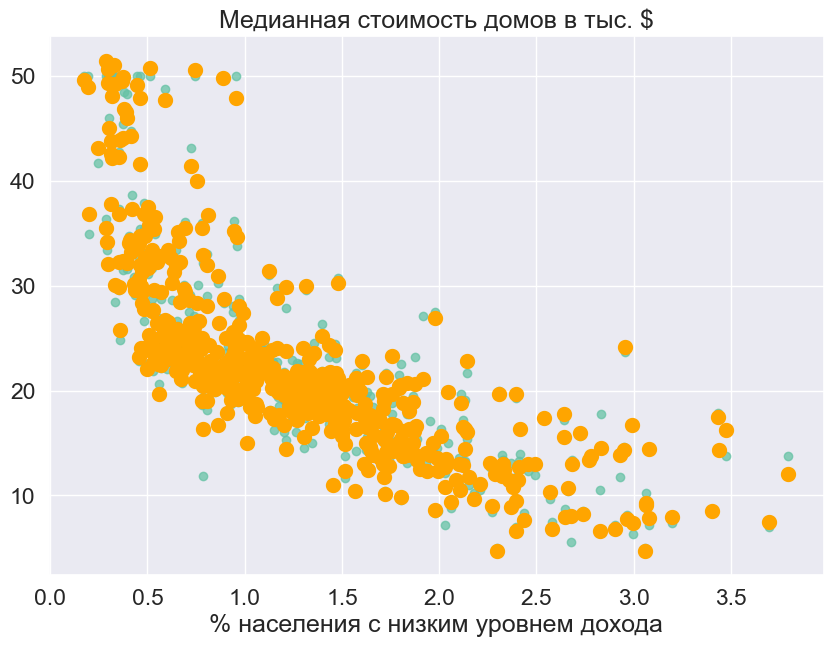

MSE = 1.290


In [41]:
# Количество итераций
num_iter = 1000

for i in range(num_iter):

    # Forward pass: предсказание модели по данным x_new
    y_pred = model(x_new)

    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_new)

    # Bakcward pass: вычисление градиентов оптимизируемой функции 
    # по всем параметрам модели
    loss.backward()

    # Оптимизация: обновление параметров по формулам соответствующего 
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 200 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 1:
            print("Готово!")
            break
    

In [ ]:
loss.item()

С чем может быть связано изменение качества?

**Ответ:** Качество предсказания значительно улучшается за счёт:
- расширения признакового пространства  
- увеличения глубины нейронной сети
- более продолжительного времени обучения
При этом сеть переобучается - подстраивает веса нейронов таким образом, чтобы запомнить все тренировочные сэпмлы. Этот эффект в общем случае нежелателен - теряется обобщающая сила модели. 